## **Argentina heatwave study December 2022**
- does Bayesian parameter estimation make much difference?
- how (in)appropriate is the linear fit?
- is a non-zero shape parameter actually supported by the data?
- model fit for first couple of periods is quite erratic: should we be trimming the ERA5 data?

In [1]:
source("../methods_extRemes.r")

df = merge(read.csv("../90_data/gmst.csv"), read.csv("AR-PY_tasmax-7day_ERA5.dat", skip = 3, sep = " ", header = F, col.names = c("year", "tmax")))
event_value <- df[df$year == 2022,"tmax"]
event_gmst <- df[df$year == 2022,"gmst"]

---
### **Rolling estimates of parameters (shift fit only)**

In [43]:
# Fit model to full available time series (ML estimation)
mle_fit <- fevd(x=tmax, data=df, location.fun=~gmst, type="GEV")
mle_par_ests <- mle_fit$results$par
mle_lss <- sgev_pars(mle_fit, covariate = event_gmst)
mle_nll <- mle_fit$results$value / length(mle_fit$x) * 30

In [3]:
# ML estimates for n-year moving window
mw = 30
ylist <- seq(min(df$year), max(df$year)-mw)

model_list <- lapply(ylist, function(y) {
    y_df = df[(df$year >= y) & (df$year < y+mw),]
    fitted = fevd(x=tmax, data=y_df, location.fun=~gmst, type="GEV", optim.args = list(method = "Nelder-Mead"))
    return(fitted)
})
mw_par_ests = data.frame(do.call("rbind", lapply(model_list, function(mdl) mdl$results$par)))
mw_lss = data.frame(do.call("rbind", lapply(model_list, function(mdl) sgev_pars(mdl, covariate = event_gmst))))
mw_nll = sapply(model_list, function(mdl) mdl$results$value)

In [57]:
# Fit model to full available time series (Bayesian - Metropolis-Hastings)
set.seed(1)
mh_fit <- fevd(x=tmax, data=df, location.fun=~gmst, type="GEV", method = "Bayesian")
mh_par_ests <- model_pars(mh_fit)
mh_lss <- sgev_pars(mh_fit, covariate = event_gmst)
mh_nll <- -mean(mh_fit$chain.info[-(1:499),"loglik"]) / length(mh_fit$x) * 30

In [56]:
# Bayesian estimates for n-year moving window (abount 3 mins)
# set.seed(1)
# model_list_mh <- lapply(ylist, function(y) {
#     y_df = df[(df$year >= y) & (df$year < y+mw),]
#     fitted = fevd(x=tmax, data=y_df, location.fun=~gmst, type="GEV", method = "Bayesian")
#     return(fitted)
# })
# save(model_list_mh, file = "data/bayesian_mw_fits.Rdata")
load("data/bayesian_mw_fits.Rdata")

mw_par_ests_mh = data.frame(do.call("rbind", lapply(model_list_mh, model_pars)))
mw_lss_mh = data.frame(do.call("rbind", lapply(model_list_mh, function(mdl) sgev_pars(mdl, covariate = event_gmst))))
mw_nll_mh = -sapply(model_list_mh, function(mdl) mean(mdl$chain.info[-(1:499),"loglik"]))

In [85]:
add_legend <- function(pos = "topleft") legend(pos, legend = c("ML", "Bayesian"), col = c("black", "blue"), pch = c(20,4), lty = 2, merge = T, bty = "n")

#### **Fitted model parameters**

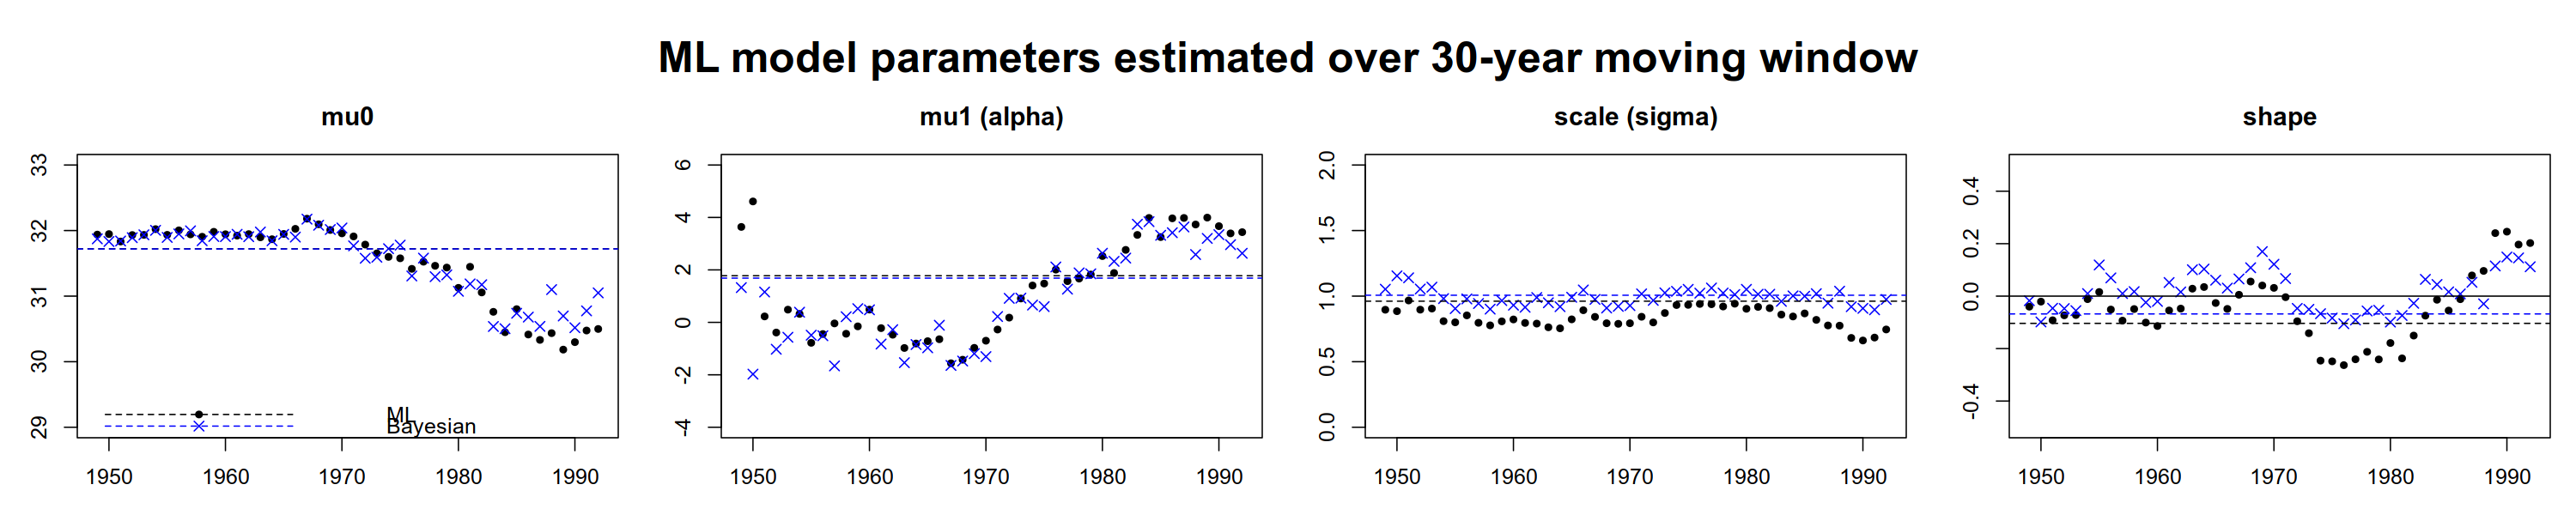

In [86]:
par(mfrow = c(1,4), pch = 20, cex = 1, oma = c(0,0,3,0), mar = c(3,3,3,1)); options(repr.plot.width = 5*4, repr.plot.height = 4*1, repr.plot.res = 150)
    
    plot(ylist, mw_par_ests$mu0, ylim = c(29,33), main = "mu0", xlab = "MW start")
    points(ylist, mw_par_ests_mh$mu0, pch = 4, col = "blue")
    abline(h = mle_par_ests["mu0"], lty = 2)
    abline(h = mh_par_ests["mu0"], lty = 2, col = "blue")

    add_legend("bottomleft")

    plot(ylist, mw_par_ests$mu1, ylim = c(-4,6), main = "mu1 (alpha)", xlab = "MW start")
    points(ylist, mw_par_ests_mh$mu1, pch = 4, col = "blue")
    abline(h = mle_par_ests["mu1"], lty = 2)
    abline(h = mh_par_ests["mu1"], lty = 2, col = "blue")
    
    plot(ylist, mw_par_ests$scale, ylim = c(0,2), main = "scale (sigma)", xlab = "MW start")
    points(ylist, mw_par_ests_mh$sigma0, pch = 4, col = "blue")
    abline(h = mle_par_ests["scale"], lty = 2)
    abline(h = mh_par_ests["sigma0"], lty = 2, col = "blue")
                                                 
    plot(ylist, mw_par_ests$shape, ylim = c(-0.5,0.5), main = "shape", xlab = "MW start")
    points(ylist, mw_par_ests_mh$shape, pch = 4, col = "blue")
    abline(h = mle_par_ests["shape"], lty = 2)
    abline(h = mh_par_ests["shape"], lty = 2, col = "blue")
    abline(h = 0)
    
    mtext(paste0("ML model parameters estimated over ",mw,"-year moving window"), side = 3, font = 2, cex = 2, outer = TRUE)

#### **Location, shape, scale**

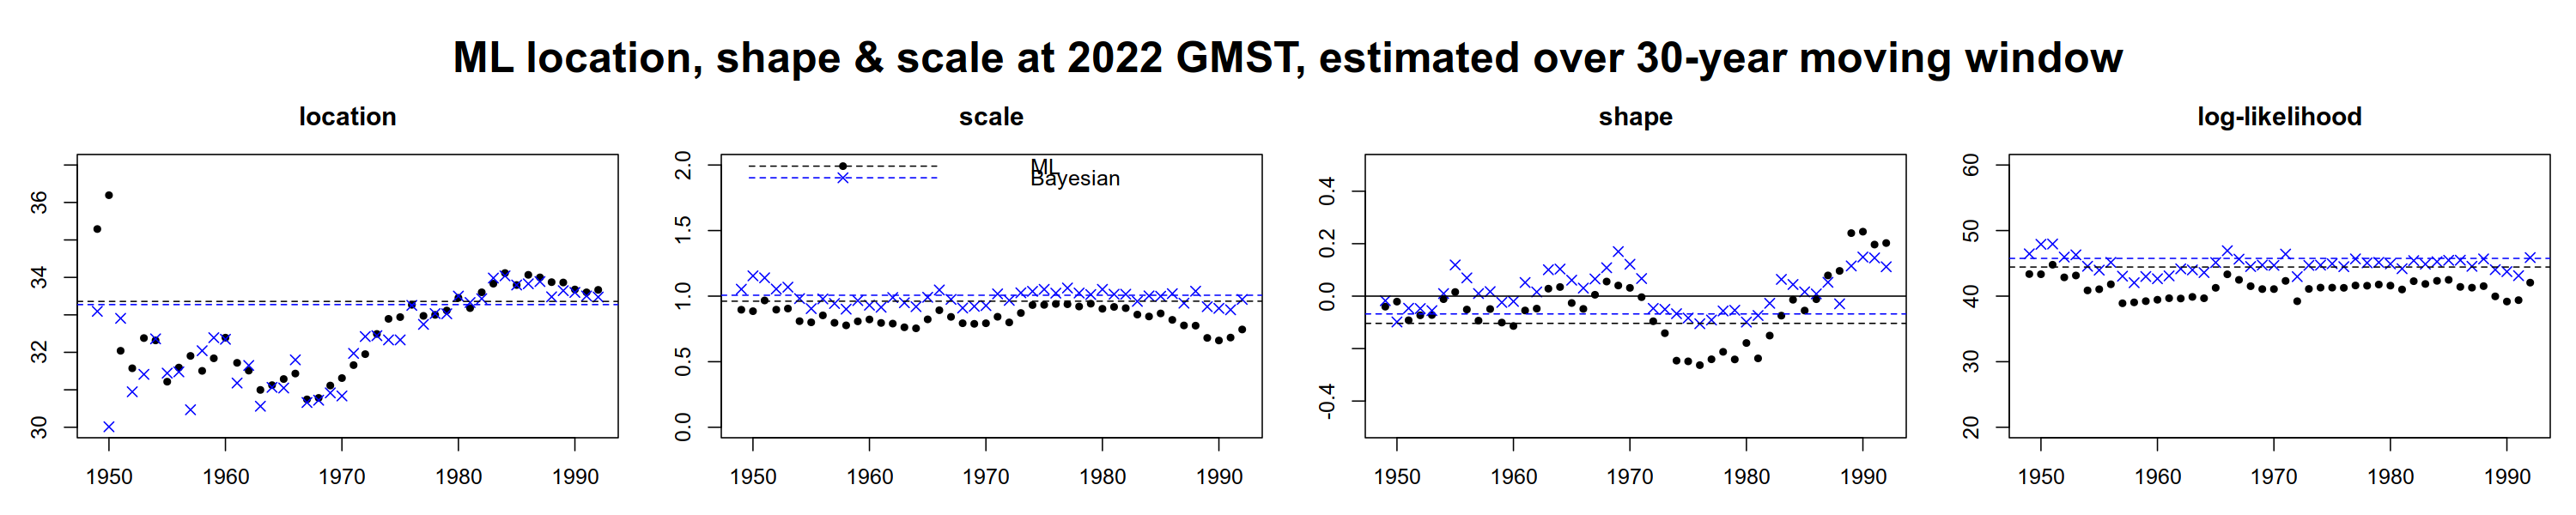

In [89]:
par(mfrow = c(1,4), pch = 20, cex = 1, oma = c(0,0,3,0), mar = c(3,3,3,1)); options(repr.plot.width = 5*4, repr.plot.height = 4*1, repr.plot.res = 150)
    
    plot(ylist, mw_lss$loc, ylim = c(30,37), main = "location", xlab = "MW start")
    points(ylist, mw_lss_mh$loc, pch = 4, col = "blue")
    abline(h = mle_lss["loc"], lty = 2)
    abline(h = mh_lss["loc"], lty = 2, col = "blue")
    
    plot(ylist, mw_lss$scale, ylim = c(0,2), main = "scale", xlab = "MW start")
    points(ylist, mw_lss_mh$scale, pch = 4, col = "blue")
    abline(h = mle_lss["scale"], lty = 2)
    abline(h = mh_lss["scale"], lty = 2, col = "blue")

    add_legend("topleft")

    plot(ylist, mw_lss$shape, ylim = c(-0.5,0.5), main = "shape", xlab = "MW start")
    points(ylist, mw_lss_mh$shape, pch = 4, col = "blue")
    abline(h = mle_lss["shape"], lty = 2)
    abline(h = mh_lss["shape"], lty = 2, col = "blue")
    abline(h = 0)

    plot(ylist, mw_nll, main = "log-likelihood", ylim = c(20,60), xlab = "MW start")
    points(ylist, mw_nll_mh, pch = 4, col = "blue")
    abline(h = mle_nll, lty = 2)
    abline(h = mh_nll, lty = 2, col = "blue")

    mtext(paste0("ML location, shape & scale at 2022 GMST, estimated over ",mw,"-year moving window"), side = 3, font = 2, cex = 2, outer = TRUE)

#### **Return periods & return levels**

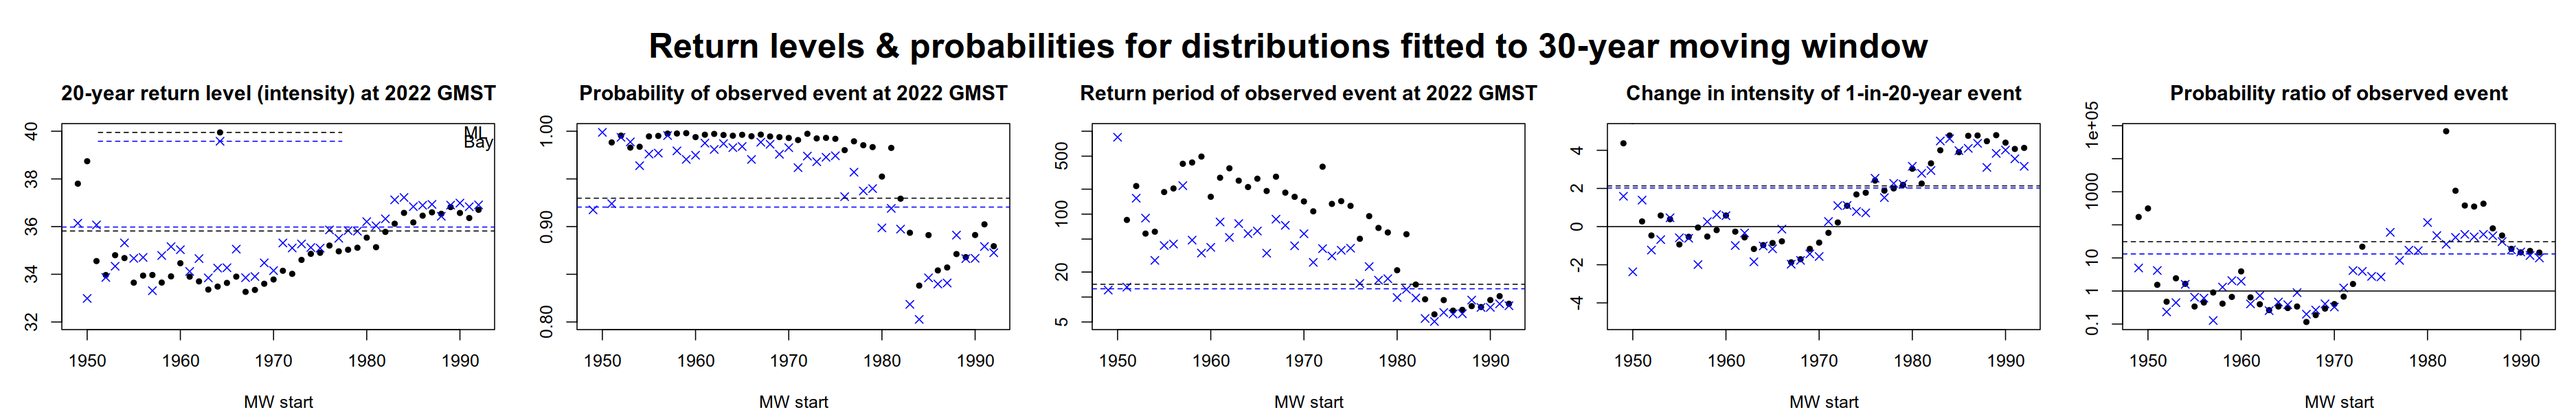

In [91]:
par(mfrow = c(1,5), pch = 20, cex = 1, oma = c(0,0,3,0), mar = c(4,3,3,1)); options(repr.plot.width = 5*5, repr.plot.height = 4*1, repr.plot.res = 150)

rp <- 20
plot(ylist, sapply(model_list, return_level, rp, event_gmst), main = paste0(rp,"-year return level (intensity) at 2022 GMST"), pch = 20, ylim = c(32,40), xlab = "MW start")
points(ylist, sapply(model_list_mh, return_level, rp, event_gmst), pch = 4, col = "blue")
abline(h = return_level(mle_fit, rp, event_gmst), lty = 2)
abline(h = return_level(mh_fit, rp, event_gmst), lty = 2, col = "blue")

add_legend("topleft")

plot(ylist, sapply(model_list, function(mdl) pextRemes(mdl, q = event_value, qcov = event_qcov(mdl, event_gmst))), ylim = c(0.8,1),
                   main = "Probability of observed event at 2022 GMST", xlab = "MW start")
points(ylist, sapply(model_list_mh, function(mdl) pextRemes(mdl, q = event_value, qcov = event_qcov(mdl, event_gmst))), pch = 4, col = "blue")
abline(h = pextRemes(mle_fit, q = event_value, qcov = event_qcov(mle_fit, event_gmst)), lty = 2)
abline(h = pextRemes(mh_fit, q = event_value, qcov = event_qcov(mh_fit, event_gmst)), lty = 2, col = "blue")
                     
plot(ylist, 1/(1-sapply(model_list, function(mdl) pextRemes(mdl, q = event_value, qcov = event_qcov(mdl, event_gmst)))), log = "y", xlab = "MW start", ylim = c(5,1000),
                   main = "Return period of observed event at 2022 GMST")
points(ylist, 1/(1-sapply(model_list_mh, function(mdl) pextRemes(mdl, q = event_value, qcov = event_qcov(mdl, event_gmst)))), pch = 4, col = "blue")
abline(h = 1/(1-pextRemes(mle_fit, q = event_value, qcov = event_qcov(mle_fit, event_gmst))), lty = 2, xlab = "MW start")
abline(h = 1/(1-pextRemes(mh_fit, q = event_value, qcov = event_qcov(mh_fit, event_gmst))), lty = 2, col = "blue")

plot(ylist, sapply(model_list, delta_I, rp, event_gmst, event_gmst - 1.2), main = paste0("Change in intensity of 1-in-",rp,"-year event"), ylim = c(-5,5), xlab = "MW start")
points(ylist, sapply(model_list_mh, delta_I, rp, event_gmst, event_gmst - 1.2), pch = 4, col = "blue")
abline(h = delta_I(mle_fit, rp, event_gmst, event_gmst - 1.2), lty = 2)
abline(h = delta_I(mh_fit, rp, event_gmst, event_gmst - 1.2), lty = 2, col = "blue")
abline(h = 0)
               
plot(ylist, sapply(model_list, prob_ratio, event_value, event_gmst, event_gmst - 1.2), main = paste0("Probability ratio of observed event"), xlab = "MW start", log = "y", yaxt = "n")
points(ylist, sapply(model_list_mh, prob_ratio, event_value, event_gmst, event_gmst - 1.2), pch = 4, col = "blue")
abline(h = prob_ratio(mle_fit, event_value, event_gmst, event_gmst - 1.2), lty = 2)
abline(h = prob_ratio(mh_fit, event_value, event_gmst, event_gmst - 1.2), lty = 2, col = "blue")
abline(h = 1)
axis(2, at = 10^c(-1:5), labels = formatC(10^c(-1:5)))
               
mtext(paste0("Return levels & probabilities for distributions fitted to ",mw,"-year moving window"), side = 3, font = 2, cex = 2, outer = TRUE)

---
### **LR tests of number of parameters needed**
- in this study, including a non-zero shape parameter doesn't appreciably improve the fit
- shifting the distribution brings a significant improvement, but scaling it does not.

In [17]:
fit_sgumbel <- fevd(x=tmax, data=df, type="Gumbel")
fit_nsgumbel <- fevd(x=tmax, data=df, location.fun=~gmst, type="Gumbel")
fit_ssgumbel <- fevd(x=tmax, data=df, location.fun=~gmst, scale.fun=~gmst, type="Gumbel")

fit_sgev <- fevd(x=tmax, data=df, type="GEV")
fit_nsgev <- fevd(x=tmax, data=df, location.fun=~gmst, type="GEV")
fit_ssgev <- fevd(x=tmax, data=df, location.fun=~gmst, scale.fun=~gmst, type="GEV")

In [29]:
data.frame(list("Gumbel shift" = unname(lr.test(fit_sgumbel, fit_nsgumbel)$p.value),
                "Gumbel shift+scale" = unname(lr.test(fit_nsgumbel, fit_ssgumbel)$p.value),
                "GEV shift" = unname(lr.test(fit_sgev, fit_nsgev)$p.value),
                "GEV or Gumbel shift" = unname(lr.test(fit_nsgumbel, fit_nsgev)$p.value),
                "Gumbel shift+scale" = unname(lr.test(fit_nsgumbel, fit_ssgumbel)$p.value)))

Gumbel.shift,Gumbel.shift.scale,GEV.shift,GEV.or.Gumbel.shift,Gumbel.shift.scale.1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.44661e-05,0.6951966,1.752662e-05,0.2702736,0.6951966


In [83]:
df["gmst2"] <- df$gmst^2
fit_nsgumbel_quadratic <- fevd(x=tmax, data=df, location.fun=~gmst2, type="Gumbel")
# can't use LR test because same number of parameters in each model
# AIC  is slightly lower for quadratic model

In [89]:
summary(fit_nsgumbel, silent = T)$AIC
summary(fit_nsgumbel_quadratic, silent = T)$AIC

[1] 226.4486

[1] 221.6783

In [88]:
summary(fit_nsgumbel, silent = T)$BIC
summary(fit_nsgumbel_quadratic, silent = T)$BIC

[1] 233.3608

[1] 228.5905

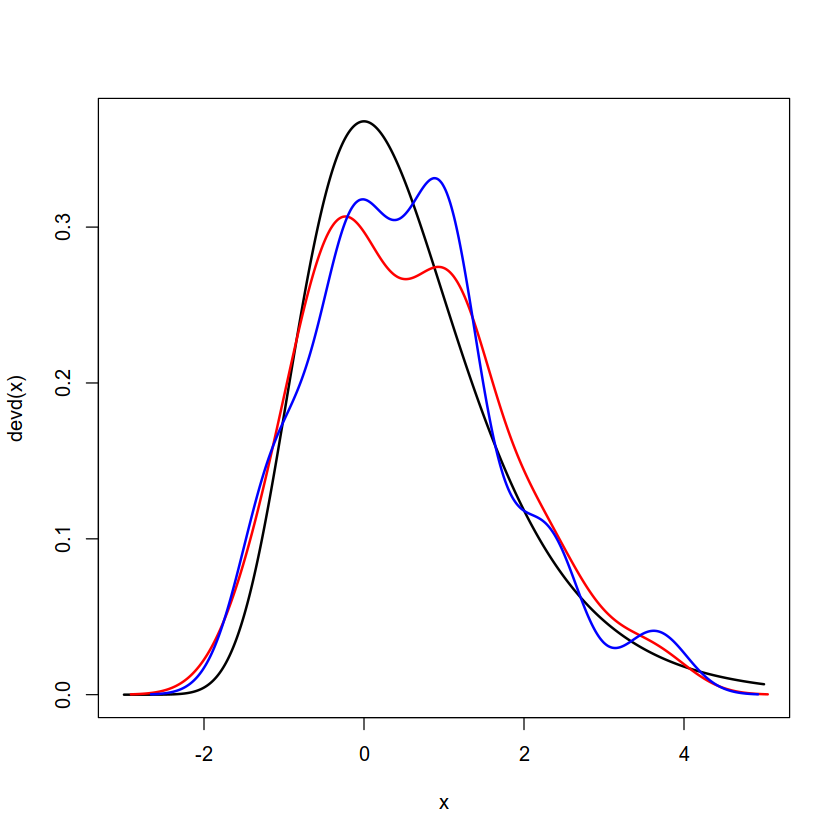

In [81]:
x <- seq(-3,5,0.01)
plot(x, devd(x), type = "l", lwd = 2)
lines(density(trans(fit_nsgumbel_quadratic)), lwd = 2, col = "red")
lines(density(trans(fit_nsgumbel)), lwd = 2, col = "blue")